In [1]:
import numpy as np
import seaborn as sns
from tqdm import tqdm

from CRDDM.Models import CDM

import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution as DE

# 1) Fixed threshold:

## 1.1) Simulation:

In [2]:
threshold = 2
drift_vector = np.array([2, 0])
ndt = 0.3

model = CDM.FixedThresholdCDM()

df = model.simulate(threshold, drift_vector, ndt, n_sample=10000)

In [3]:
df

,rt,response
0,0.924,-0.400388
1,1.257,-0.345536
2,0.682,0.680642
3,1.497,0.126102
4,0.735,-0.152880
...,...,...
9995,0.863,-0.415713
9996,0.989,0.800202
9997,0.699,-0.234179
9998,0.733,0.018257


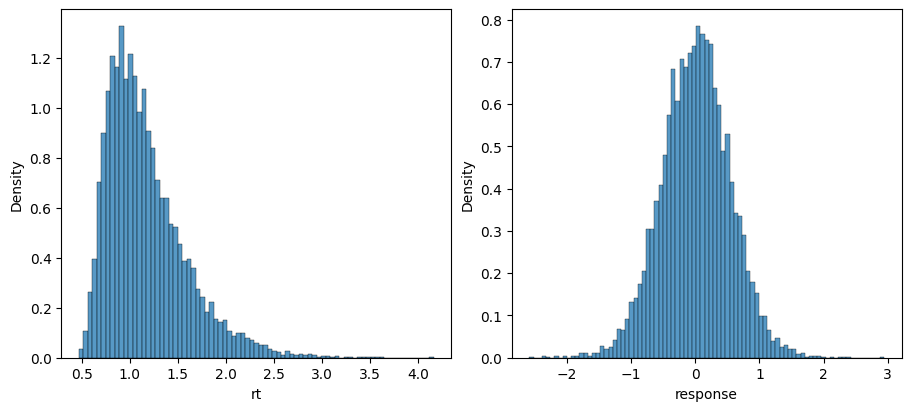

In [4]:
plt.figure(figsize=(9, 4), layout='constrained')
plt.subplot(121)
sns.histplot(df['rt'], stat='density');

plt.subplot(122)
theta = np.linspace(-3.14, 3.14, 200)
sns.histplot(df['response'], stat='density');

## 1.2) Parameter recovery (no drift variability):

In [5]:
def fit_cdm(prms, rt, theta, model):
    threshold =  prms[0] # decision threshold
    ndt = prms[1] # non-decision time
    drift_vec = np.array([prms[2], prms[3]]) # drift vector [drift_x, drift_y]
    
    return -np.sum(model.joint_lpdf(rt, theta, threshold, drift_vec, ndt))

In [6]:
n_trials = 300
recovery_df = {'threshold_true': [],
               'threshold_estimate': [],
               'ndt_true': [],
               'ndt_estimate': [],
               'mu_x_true': [],
               'mu_x_estimate': [],
               'mu_y_true': [],
               'mu_y_estimate': []}

# These are the bounds for parameter estimation
min_threshold = 0.05
max_threshold = 5

min_ndt = 0
max_ndt = 2

min_mu = -5
max_mu = 5

prms_bounds = [(min_threshold, max_threshold), 
               (min_ndt, max_ndt),
               (min_mu, max_mu), 
               (min_mu, max_mu)]

In [7]:
for n in tqdm(range(5)):
    model = CDM.FixedThresholdCDM()
    # generating some random parameters
    threshold = np.random.uniform(0.5, max_threshold)
    mu_x = np.random.uniform(min_mu, max_mu)
    mu_y = np.random.uniform(min_mu, max_mu)
    drift_vector = np.array([mu_x, mu_y])
    ndt = np.random.uniform(0.05, max_ndt)
    
    sim_df = model.simulate(threshold, drift_vector, ndt, n_sample=n_trials)
    
    # Estimating the paramters for the simulated data
    min_ans = DE(fit_cdm, 
                 args=(sim_df['rt'].values, sim_df['response'].values, model), 
                 bounds=prms_bounds)

    
    # Storing the true generating parameters
    recovery_df['threshold_true'].append(threshold)
    recovery_df['ndt_true'].append(ndt)
    recovery_df['mu_x_true'].append(mu_x)
    recovery_df['mu_y_true'].append(mu_y)
    
    # Stroing the estimated parameters
    recovery_df['threshold_estimate'].append(min_ans.x[0])
    recovery_df['ndt_estimate'].append(min_ans.x[1])
    recovery_df['mu_x_estimate'].append(min_ans.x[2])
    recovery_df['mu_y_estimate'].append(min_ans.x[3])

100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


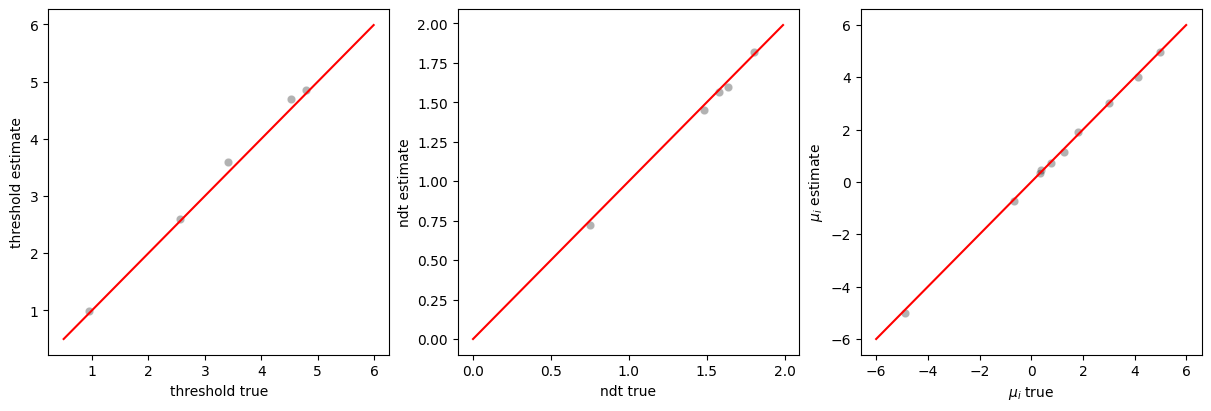

In [8]:
plt.figure(figsize=(12, 4), layout='constrained')

plt.subplot(131)
plt.plot(np.arange(.5, 6, 0.01), np.arange(.5, 6, 0.01), c='red')
sns.scatterplot(x='threshold_true', y='threshold_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'threshold true')
plt.ylabel(r'threshold estimate')

plt.subplot(132)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'ndt true')
plt.ylabel(r'ndt estimate')

plt.subplot(133)
plt.plot(np.arange(-6, 6, 0.01), np.arange(-6, 6, 0.01), c='red')
sns.scatterplot(x='mu_x_true', y='mu_x_estimate', data=recovery_df, color='black', alpha=0.3);
sns.scatterplot(x='mu_y_true', y='mu_y_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'$\mu_i$ true')
plt.ylabel(r'$\mu_i$ estimate');


## 1.3) Parameter recovery (with drift variability):

In [9]:
def fit_cdm_drift_var(prms, rt, theta, model):
    threshold =  prms[0] # decision threshold
    ndt = prms[1] # non-decision time
    drift_vec = np.array([prms[2], prms[3]]) # drift vector [drift_x, drift_y]
    s_v = prms[4] # drift variability
    
    return -np.sum(model.joint_lpdf(rt, theta, threshold, drift_vec, ndt, s_v=s_v))

In [10]:
n_trials = 300
recovery_df = {'threshold_true': [],
               'threshold_estimate': [],
               'ndt_true': [],
               'ndt_estimate': [],
               'mu_x_true': [],
               'mu_x_estimate': [],
               'mu_y_true': [],
               'mu_y_estimate': [],
               's_v_true':[],
               's_v_estimate':[]}

# These are the bounds for parameter estimation
min_threshold = 0.05
max_threshold = 5

min_ndt = 0
max_ndt = 2

min_mu = -5
max_mu = 5

min_s_v = 0.05
max_s_v = 1

prms_bounds = [(min_threshold, max_threshold), 
               (min_ndt, max_ndt),
               (min_mu, max_mu), 
               (min_mu, max_mu),
               (min_s_v, max_s_v)]

In [11]:
for n in tqdm(range(5)):
    model = CDM.FixedThresholdCDM()
    # generating some random parameters
    threshold = np.random.uniform(0.5, max_threshold)
    ndt = np.random.uniform(0.05, max_ndt)
    mu_x = np.random.uniform(min_mu, max_mu)
    mu_y = np.random.uniform(min_mu, max_mu)
    drift_vector = np.array([mu_x, mu_y])
    s_v = np.random.uniform(min_s_v, max_s_v)
    
    sim_df = model.simulate(threshold, drift_vector, ndt, s_v=s_v, n_sample=n_trials)
    
    # Estimating the paramters for the simulated data
    min_ans = DE(fit_cdm_drift_var, 
                 args=(sim_df['rt'].values, sim_df['response'].values, model), 
                 bounds=prms_bounds)

    
    # Storing the true generating parameters
    recovery_df['threshold_true'].append(threshold)
    recovery_df['ndt_true'].append(ndt)
    recovery_df['mu_x_true'].append(mu_x)
    recovery_df['mu_y_true'].append(mu_y)
    recovery_df['s_v_true'].append(s_v)
    
    # Stroing the estimated parameters
    recovery_df['threshold_estimate'].append(min_ans.x[0])
    recovery_df['ndt_estimate'].append(min_ans.x[1])
    recovery_df['mu_x_estimate'].append(min_ans.x[2])
    recovery_df['mu_y_estimate'].append(min_ans.x[3])
    recovery_df['s_v_estimate'].append(min_ans.x[4])

100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


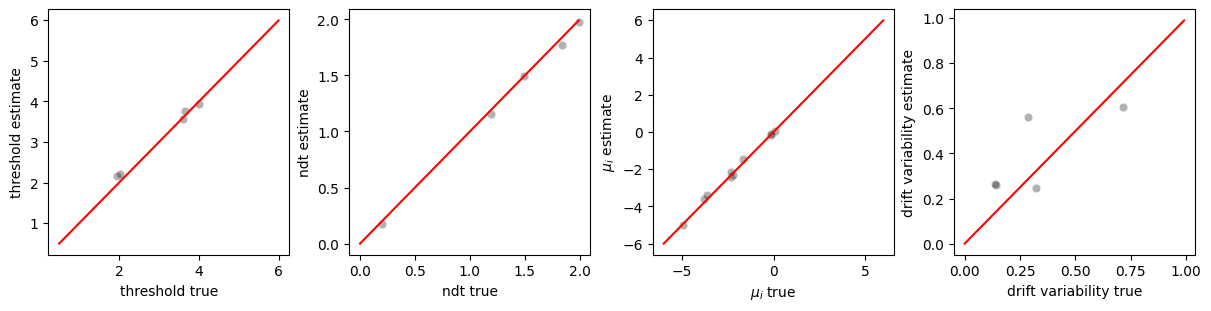

In [12]:
plt.figure(figsize=(12, 3), layout='constrained')

plt.subplot(141)
plt.plot(np.arange(.5, 6, 0.01), np.arange(.5, 6, 0.01), c='red')
sns.scatterplot(x='threshold_true', y='threshold_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'threshold true')
plt.ylabel(r'threshold estimate')

plt.subplot(142)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'ndt true')
plt.ylabel(r'ndt estimate')

plt.subplot(143)
plt.plot(np.arange(-6, 6, 0.01), np.arange(-6, 6, 0.01), c='red')
sns.scatterplot(x='mu_x_true', y='mu_x_estimate', data=recovery_df, color='black', alpha=0.3);
sns.scatterplot(x='mu_y_true', y='mu_y_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'$\mu_i$ true')
plt.ylabel(r'$\mu_i$ estimate');

plt.subplot(144)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='red')
sns.scatterplot(x='s_v_true', y='s_v_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'drift variability true')
plt.ylabel(r'drift variability estimate');

# 2) Collapsing threshold:

## 2.1) Simulation:

In [13]:
threshold = 3
decay = 0.7
drift_vector = np.array([1, 0])
ndt = 0.3

cdm = CDM.CollapsingThresholdCDM()

df = cdm.simulate(threshold, 
                  decay, 
                  drift_vector, 
                  ndt, 
                  n_sample=10000)

In [14]:
df

,rt,response
0,1.645,0.109936
1,2.560,1.487439
2,1.250,0.638003
3,1.848,-0.516961
4,1.656,-0.119601
...,...,...
9995,1.418,1.015536
9996,1.486,-0.274651
9997,2.486,0.725333
9998,2.516,-0.652673


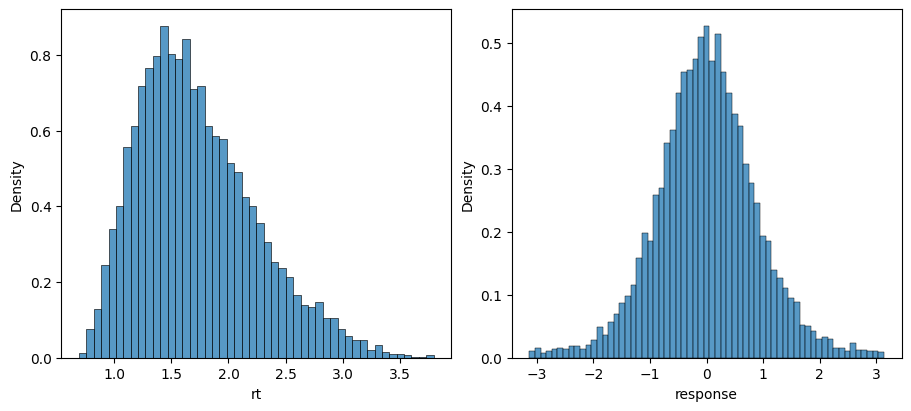

In [15]:
plt.figure(figsize=(9, 4), layout='constrained')
plt.subplot(121)
sns.histplot(df['rt'], stat='density');

plt.subplot(122)
theta = np.linspace(-3.14, 3.14, 200)
sns.histplot(df['response'], stat='density');

## 2.2) Parameter recovery (no drift variability):

In [16]:
def fit_cb_cdm(prms, rt, theta, model):
    threshold =  prms[0] # decision threshold
    decay = prms [1]
    ndt = prms[2] # non-decision time
    drift_vec = np.array([prms[3], prms[4]]) # drift vector
    
    return -np.sum(model.joint_lpdf(rt, theta, 
                                    threshold, decay, 
                                    drift_vec, ndt))

In [17]:
n_trials = 1000
recovery_df = {'threshold_true': [],
               'threshold_estimate': [],
               'decay_true':[],
               'decay_estimate':[],
               'ndt_true': [],
               'ndt_estimate': [],
               'mu_x_true': [],
               'mu_x_estimate': [],
               'mu_y_true': [],
               'mu_y_estimate': []}

# These are the bounds for parameter estimation
min_threshold = 2
max_threshold = 5

min_decay = 0.05
max_decay = 2

min_ndt = 0
max_ndt = 2

min_mu = -5
max_mu = 5

prms_bounds = [(min_threshold, max_threshold), 
               (min_decay, max_decay), 
               (min_ndt, max_ndt), 
               (min_mu, max_mu), 
               (min_mu, max_mu)]

In [18]:
for n in tqdm(range(5)):
    model = CDM.CollapsingThresholdCDM()
    # generating some random parameters
    threshold = np.random.uniform(min_threshold, max_threshold)
    decay = np.random.uniform(min_decay, max_decay)
    mu_x = np.random.uniform(min_mu, max_mu)
    mu_y = np.random.uniform(min_mu, max_mu)
    drift_vector = np.array([mu_x, mu_y])
    ndt = np.random.uniform(0.05, max_ndt)
    
    sim_df = model.simulate(threshold, 
                            decay, 
                            drift_vector, 
                            ndt, 
                            n_sample=n_trials)
    
    # Estimating the paramters for the simulated data
    min_ans = DE(fit_cb_cdm, args=(sim_df['rt'].values, sim_df['response'].values, model), bounds=prms_bounds)

    
    # Storing the true generating parameters
    recovery_df['threshold_true'].append(threshold)
    recovery_df['decay_true'].append(decay)
    recovery_df['ndt_true'].append(ndt)
    recovery_df['mu_x_true'].append(mu_x)
    recovery_df['mu_y_true'].append(mu_y)
    
    # Stroing the estimated parameters
    recovery_df['threshold_estimate'].append(min_ans.x[0])
    recovery_df['decay_estimate'].append(min_ans.x[1])
    recovery_df['ndt_estimate'].append(min_ans.x[2])
    recovery_df['mu_x_estimate'].append(min_ans.x[3])
    recovery_df['mu_y_estimate'].append(min_ans.x[4])

100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.71s/it]


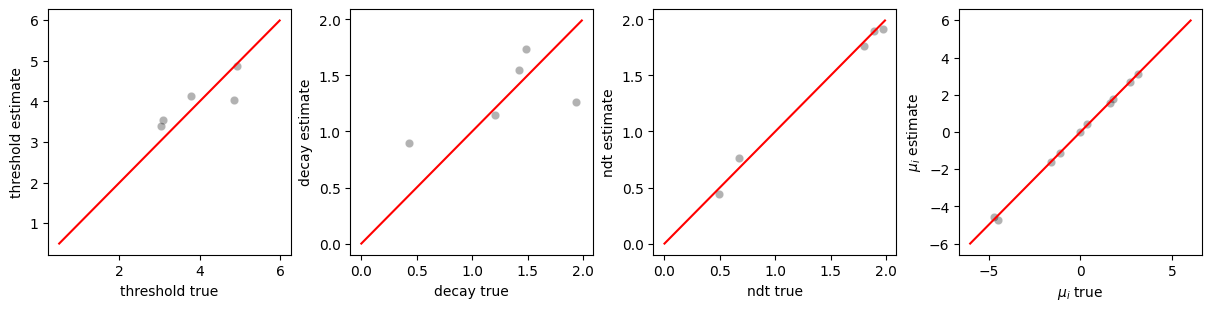

In [19]:
plt.figure(figsize=(12, 3), layout='constrained')

plt.subplot(141)
plt.plot(np.arange(.5, 6, 0.01), np.arange(.5, 6, 0.01), c='red')
sns.scatterplot(x='threshold_true', y='threshold_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'threshold true')
plt.ylabel(r'threshold estimate')

plt.subplot(142)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='decay_true', y='decay_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'decay true')
plt.ylabel(r'decay estimate')

plt.subplot(143)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'ndt true')
plt.ylabel(r'ndt estimate')

plt.subplot(144)
plt.plot(np.arange(-6, 6, 0.01), np.arange(-6, 6, 0.01), c='red')
sns.scatterplot(x='mu_x_true', y='mu_x_estimate', data=recovery_df, color='black', alpha=0.3);
sns.scatterplot(x='mu_y_true', y='mu_y_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'$\mu_i$ true')
plt.ylabel(r'$\mu_i$ estimate');

## 1.3) Parameter recovery (with drift variability):

In [20]:
def fit_cb_cdm_drift_var(prms, rt, theta, model):
    threshold =  prms[0] # decision threshold
    decay = prms [1]
    ndt = prms[2] # non-decision time
    drift_vec = np.array([prms[3], prms[4]]) # drift vector
    s_v = prms[5] # drift variability
    
    return -np.sum(model.joint_lpdf(rt, theta, 
                                    threshold, decay, 
                                    drift_vec, ndt, s_v=s_v))

In [21]:
n_trials = 1000
recovery_df = {'threshold_true': [],
               'threshold_estimate': [],
               'decay_true':[],
               'decay_estimate':[],
               'ndt_true': [],
               'ndt_estimate': [],
               'mu_x_true': [],
               'mu_x_estimate': [],
               'mu_y_true': [],
               'mu_y_estimate': [],
               's_v_true':[],
               's_v_estimate':[]}

# These are the bounds for parameter estimation
min_threshold = 2
max_threshold = 5

min_decay = 0.05
max_decay = 2

min_ndt = 0
max_ndt = 2

min_mu = -5
max_mu = 5

min_s_v = 0.05
max_s_v = 1

prms_bounds = [(min_threshold, max_threshold), 
               (min_decay, max_decay), 
               (min_ndt, max_ndt), 
               (min_mu, max_mu), 
               (min_mu, max_mu),
               (min_s_v, max_s_v)]

In [22]:
for n in tqdm(range(5)):
    model = CDM.CollapsingThresholdCDM()
    # generating some random parameters
    threshold = np.random.uniform(min_threshold, max_threshold)
    decay = np.random.uniform(min_decay, max_decay)
    mu_x = np.random.uniform(min_mu, max_mu)
    mu_y = np.random.uniform(min_mu, max_mu)
    drift_vector = np.array([mu_x, mu_y])
    ndt = np.random.uniform(0.05, max_ndt)
    s_v = np.random.uniform(min_s_v, max_s_v)
    
    sim_df = model.simulate(threshold, 
                            decay, 
                            drift_vector, 
                            ndt,
                            s_v = s_v,
                            n_sample=n_trials)
    
    # Estimating the paramters for the simulated data
    min_ans = DE(fit_cb_cdm_drift_var, 
                 args=(sim_df['rt'].values, sim_df['response'].values, model), 
                 bounds=prms_bounds)

    
    # Storing the true generating parameters
    recovery_df['threshold_true'].append(threshold)
    recovery_df['decay_true'].append(decay)
    recovery_df['ndt_true'].append(ndt)
    recovery_df['mu_x_true'].append(mu_x)
    recovery_df['mu_y_true'].append(mu_y)
    recovery_df['s_v_true'].append(s_v)
    
    # Stroing the estimated parameters
    recovery_df['threshold_estimate'].append(min_ans.x[0])
    recovery_df['decay_estimate'].append(min_ans.x[1])
    recovery_df['ndt_estimate'].append(min_ans.x[2])
    recovery_df['mu_x_estimate'].append(min_ans.x[3])
    recovery_df['mu_y_estimate'].append(min_ans.x[4])
    recovery_df['s_v_estimate'].append(min_ans.x[5])

100%|█████████████████████████████████████████████| 5/5 [00:41<00:00,  8.30s/it]


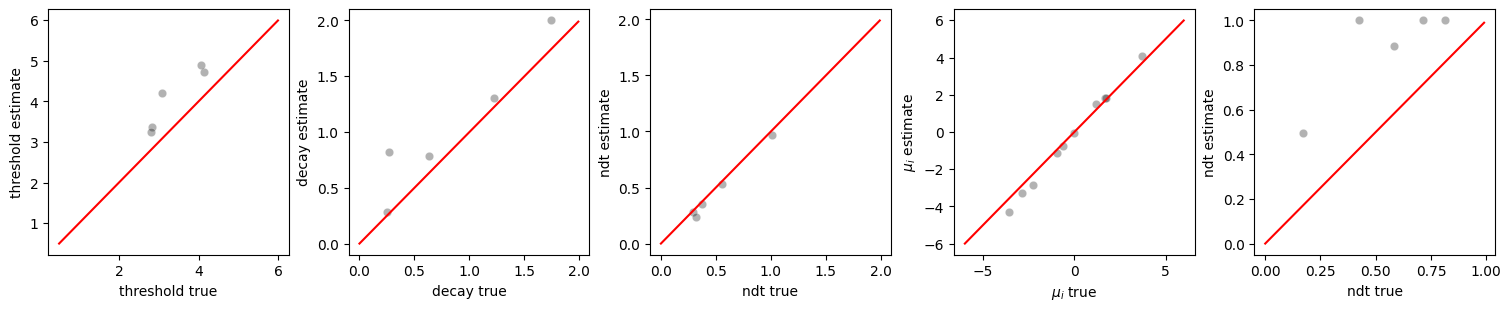

In [24]:
plt.figure(figsize=(15, 3), layout='constrained')

plt.subplot(151)
plt.plot(np.arange(.5, 6, 0.01), np.arange(.5, 6, 0.01), c='red')
sns.scatterplot(x='threshold_true', y='threshold_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'threshold true')
plt.ylabel(r'threshold estimate')

plt.subplot(152)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='decay_true', y='decay_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'decay true')
plt.ylabel(r'decay estimate')

plt.subplot(153)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'ndt true')
plt.ylabel(r'ndt estimate')

plt.subplot(154)
plt.plot(np.arange(-6, 6, 0.01), np.arange(-6, 6, 0.01), c='red')
sns.scatterplot(x='mu_x_true', y='mu_x_estimate', data=recovery_df, color='black', alpha=0.3);
sns.scatterplot(x='mu_y_true', y='mu_y_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'$\mu_i$ true')
plt.ylabel(r'$\mu_i$ estimate');

plt.subplot(155)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='red')
sns.scatterplot(x='s_v_true', y='s_v_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'ndt true')
plt.ylabel(r'ndt estimate');

In [2]:
model = CDM.CollapsingThresholdCDM()

In [ ]:
model.